In [1]:
# | default_exp models.linear_memory
%load_ext autoreload
%autoreload 2

# Linear Memory
> Linear associative memory model for CMR.

In [ ]:
# |exports
from jax import lax
from jax import numpy as jnp
from simple_pytree import Pytree

from jaxcmr.typing import Array, Float, Float_, Int_

In [ ]:
# | exports


class LinearMemory(Pytree):
    """Linear associative memory model for CMR.

    Attributes:
        input_size: the size of the input representation.
        output_size: the size of the output representation.
        state: the current state of the memory.
    """

    def __init__(
        self,
        state: Float[Array, " input_size output_size"],
    ):
        self.state = state
        self.input_size = self.state.shape[0]
        self.output_size = self.state.shape[1]

    def associate(
        self,
        in_pattern: Float[Array, " input_size"],
        out_pattern: Float[Array, " output_size"],
        learning_rate: Float_,
    ) -> "LinearMemory":
        """Return the updated memory after associating input and output patterns.

        Args:
            in_pattern: a feature pattern for an input.
            out_pattern: a feature pattern for an output.
            learning_rate: the learning rate parameter.
        """
        return self.replace(
            state=self.state + (learning_rate * jnp.outer(in_pattern, out_pattern))
        )

    def probe(
        self,
        in_pattern: Float[Array, " input_size"],
    ) -> Float[Array, " output_size"]:
        """Return the output pattern associated with the input pattern in memory.

        Args:
            input_pattern: the input feature pattern.
        """
        return jnp.dot(in_pattern, self.state)

    def zero_out(
        self,
        index: Int_,
    ) -> "LinearMemory":
        """Return the updated memory after zeroing out associations for a given input index.

        Args:
            index: the index to zero out.
        """
        return self.replace(state=self.state.at[index].set(0))

    @classmethod
    def init_mfc(
        cls,
        item_count: int,
        context_feature_count: int,
        learning_rate: Float_,
    ) -> "LinearMemory":
        """Return a new linear associative item-to-context memory model.

        Initially, all items are associated with a unique context unit by `1-learning_rate`.
        To allow out-of-list contexts, set context_feature_count to `list_length + 2`.
        Otherwise use `list_length+1`.

        Args:
            item_count: the number of items in the memory model.
            context_feature_count: the number of unique units in context.
            learning_rate: the learning rate parameter.
        """
        item_feature_count = item_count
        return cls(
            jnp.eye(item_feature_count, context_feature_count, 1) * (1 - learning_rate),
        )

    @classmethod
    def init_mcf(
        cls,
        item_count: int,
        context_feature_count: int,
        item_support: Float_,
        shared_support: Float_,
    ) -> "LinearMemory":
        """Return a new linear associative context-to-item memory model.

        Initially, in-list context units are associated with all items according to shared_support.
        They are also associated with a unique item according to item_support.
        Start-of-list and out-of-list context units receive no initial associations.

        To allow out-of-list contexts, set context_feature_count to `list_length + 2`.
        Otherwise use `list_length+1`.

        Args:
            item_count: the number of items in the memory model.
            context_feature_count: the number of unique units in context.
            item_support: initial association between an item and its own context feature
            shared_support: initial association between an item and all other contextual features
        """
        base_memory = jnp.full((context_feature_count - 1, item_count), shared_support)
        base_memory = lax.fori_loop(
            0, item_count, lambda i, m: m.at[i, i].set(item_support), base_memory
        )
        start_list = jnp.zeros((1, item_count))
        return cls(jnp.vstack((start_list, base_memory)))


## Notes

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from jaxcmr.state_analysis import matrix_heatmap

### Intialization

`LinearMemory` supports multiple initialization paths depending on modeling needs.

`LinearMemory.__init__` constructs a memory directly from a full weight matrix (`state`) and an `activation_scale`. This allows full control over initial associations.

In the CMR model, two linear memories are used; one to represent item-to-context associations and another for context-to-item associations. The `LinearMemory.init_mfc` method initializes the item-to-context memory, while `LinearMemory.init_mcf` initializes the context-to-item memory.

#### $M^{FC}$ Initialization

`LinearMemory.init_mfc` initializes an item-to-context memory where each item is associated with a unique context unit via strength `1 - learning_rate`. The weight matrix has shape `(item_count, context_feature_count)`. To support out-of-list context drift, set `context_feature_count = list_length + 2`.

Within CMR, we define `context_feature_count` in terms of the shape of the context representation the model is using. In our usual implementation, CMR uses one more context unit than the number of items in memory to allow for representation of a "start-of-list" context.

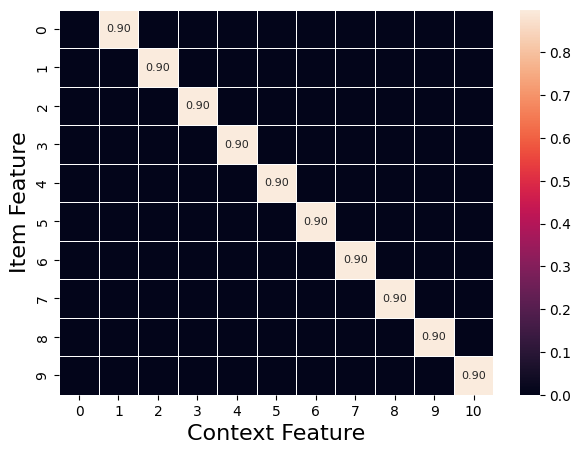

In [ ]:
item_count = 10
learning_rate = 0.1
activation_scale = 1.0
context_feature_count = item_count + 1

mfc = LinearMemory.init_mfc(item_count, context_feature_count, learning_rate)

diag_indices = jnp.diag_indices(item_count)

assert np.allclose(
    mfc.state[diag_indices[0], diag_indices[1] + 1], 1.0 - learning_rate
), "Shifted diagonal values mismatch 1-learning_rate"

assert mfc.state.shape == (item_count, item_count + 1), "State shape mismatch"

matrix_heatmap(mfc.state, figsize=(7, 5), annot_font_size=8, label_font_size=16)
plt.ylabel("Item Feature")
plt.xlabel("Context Feature");

#### $M^{CF}$ Initialization

`LinearMemory.init_mcf` initializes a context-to-item memory. 

Initially, in-list context units are associated with all items according to shared_support.
They are also associated with a unique item according to item_support.
Start-of-list and out-of-list context units receive no initial associations.

To allow out-of-list contexts, set context_feature_count to `list_length + 2`.
Otherwise use `list_length+1`.

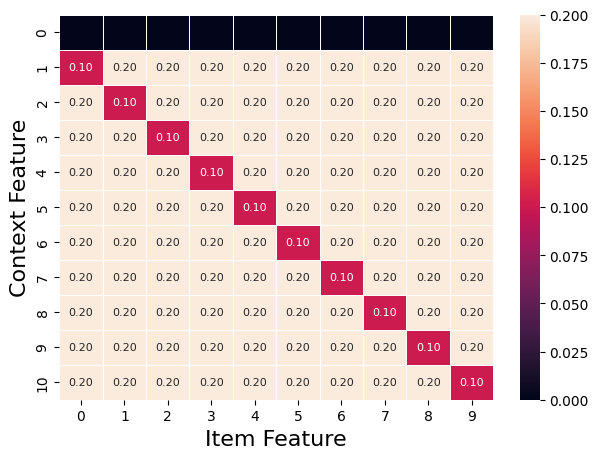

In [6]:
item_count = 10
context_feature_count = item_count + 1
item_support = 0.1
shared_support = 0.2

mcf = LinearMemory.init_mcf(
    item_count, context_feature_count, item_support, shared_support
)

diag_indices = jnp.diag_indices(item_count)
assert np.allclose(mcf.state[diag_indices[0] + 1, diag_indices[1]], item_support), (
    "diagonal values should be item_support"
)

assert np.allclose(
    mcf.state.at[diag_indices[0] + 1, diag_indices[1]].set(shared_support)[1:-1],
    shared_support,
), "off-diagonal values should be shared_support"

assert mcf.state.shape == (item_count + 1, item_count), "shape mismatch"

matrix_heatmap(mcf.state, figsize=(7, 5), annot_font_size=8, label_font_size=16)
plt.xlabel("Item Feature")
plt.ylabel("Context Feature");

### Association
Linear associative memories associate input and output patterns in a weight matrix according a [Hebbian learning rule](https://en.wikipedia.org/wiki/Hebbian_theory) where "neurons that figure to gether, wire together":

> $$w_{ij} = \sum_{k=1}^p x_i^k x_j^k $$
> 
> where $w_{ij}$ is the weight of the connection from neuron $j$ to neuron $i$, $p$ is the number of training patterns and $x_{i}^k$ the $k$-th input for neuron $i$.

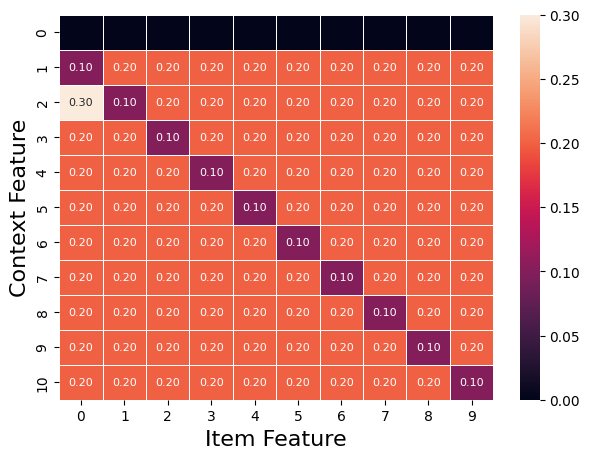

In [7]:
items = jnp.eye(item_count)
contexts = jnp.eye(item_count, item_count + 1, 1)

mcf2 = mcf.associate(contexts[1], items[0], learning_rate)
assert mcf2.state[2, 0] > mcf.state[2, 0]

matrix_heatmap(mcf2.state, figsize=(7, 5), annot_font_size=8, label_font_size=16)
plt.xlabel("Item Feature")
plt.ylabel("Context Feature");

### Probing
A dot product of the memory state and an input pattern retrieves an associated output pattern.

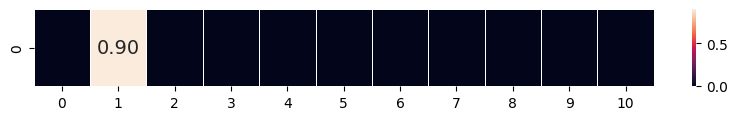

In [8]:
memory = LinearMemory.init_mfc(item_count, item_count + 1, 0.1)

items = np.eye(item_count)

activation = memory.probe(items[0])

assert activation.shape[0] == item_count + 1, "activation1 shape mismatch"

matrix_heatmap(np.expand_dims(activation, axis=0), figsize=(10, 1))
plt.xlabel("")
plt.ylabel("")
plt.show()

`LinearMemory` implements the `typing.Memory` protocol. As long as a class implements this interface, it's usable by other classes that expect a `Memory` object. This allows for easy swapping of different memory implementations without changing the rest of the code.

In [9]:
from jaxcmr.typing import Memory

In [10]:
assert isinstance(mfc, Memory), "LinearMemory should implement Memory"